# Lab Session #5
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font>  César Zapata - 02213600
<br>
<font color=blue>Academic Year:</font> 2022-2023

# Module 3: Brunel network

In this practical, you will simulate a network of sparsely connected identical Leaky-Integrate-and-Fire neurons. 

This model is based on the paper by [Brunel 2000](https://link.springer.com/article/10.1023/A:1008925309027) and is also discussed in [Neuronal Dynamics](http://neuronaldynamics.epfl.ch), see eg. Figure 13.7. 

We will show that a large network of neurons consisting of a group of excitatory and a group of inhibitory neurons that receive external input is capable of producing a rich dynamics. The parameters that we will vary to trigger different states are (1) the driving frequency of the external population and (2) the relative strength of inhibition vs excitation (g). 

To do so, we will follow two strategies both relying on the BRIAN package: the first strategy is to create our own network from scratch. This will allow you to get acquainted with the BRIAN package and will prepare you for the second strategy. Here, you will use a pre-defined spiking network (included in the BRIAN package), but you will have to make sure you understand its input and outputs in order to induce the correct behaviour. 


We start by ensuring all packages are loaded. Make sure to have installed the [Brian Package](https://briansimulator.org/) 

In [2]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools, spike_tools
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

## Step 1.1. Initialising the NeuronGroup instance

We start by defining a NeuronGroup instance. You can find the documentation [here](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.groups.neurongroup.NeuronGroup.html) 

A NeuronGroup instance takes as input the number of neurons, the dynamics of a single neuron 'model', the length of the refractory period and the integration method. Note that initialising the NeuronGroup will not yet run the simulation. Running the simulation will be done in the upcoming blocks once we have added all details to the network. 

The input parameters of the NeuronGroup instance should be: 
- number of neurons: N_Excit (4000) +N_Inhib (1000)
- the model should model the LIF dynamics
- the model should reset at a threshold v = v_reset (10 mV)
- the neurons should have an absolute refractory period (2ms)
- integration method should be linear

What is the default firing threshold? 

In [3]:
b2.start_scope()
# ADD your code here: 

N_Excit = 4000
N_Inhib = 1000
abs_refractory_period = 2 * b2.ms
v_rest = 0. * b2.mV
membrane_time_scale = 20 * b2.ms
firing_threshold = 20 * b2.mV
b2.defaultclock.dt = 0.1 * b2.ms
v_reset = 10 * b2.mV
tau = 20 *b2.ms


lif_dynamics = """ dv/dt = -v / tau : volt (unless refractory)
v0 : volt """

network = NeuronGroup(
    N_Excit+N_Inhib, model=lif_dynamics,
    threshold='v > firing_threshold', refractory=abs_refractory_period,
    method="linear",reset='v=v_reset')

print(network)
#print(network.v)

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


<div class="alert alert-success">
<span style="color:black">

**A1.1 Answer** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

## Step 1.2. Add network structure
Now that we have created a group of neurons, we will define how they are connected. In order to connect neurons to each other, we first need to distinguish the two neuronal populations (the excitatory and inhibitory population). In order to define the first N_Excit neurons to be excitatory and the remaining part to be inhibitory, you can simply use the following code snippet. 

In [4]:
excitatory_population = network[:N_Excit]
inhibitory_population = network[N_Excit:]

Now, we need to define two types of synapses: excitatory and inhibitory synapses. Allow for a synaptic delay of 1.5*b2.ms and use a random connection probability of 0.1. You can find the documentation [here](https://brian2.readthedocs.io/en/stable/user/synapses.html) 
In order to follow the notations in the book, please use following notation and default values: 

What is the "target" network? 

In [5]:
w0 = 0.1*b2.mV
g = 4.0
J_excit = w0
J_inhib = -g*w0
synaptic_delay = 1.5*b2.ms
connection_probability = 0.1

# trying this for the on_pre https://neurostars.org/t/create-excitatory-and-inhibitory-populations-in-brian2/16454
# https://brian2.readthedocs.io/en/stable/examples/frompapers.Brunel_2000.html

exc_synapses = Synapses(excitatory_population, target=network, on_pre="v += (rand() < connection_probability) * J_excit", delay=synaptic_delay)
exc_synapses.connect(p=connection_probability)

inhib_synapses = Synapses(inhibitory_population, target=network, on_pre="v += (rand() < connection_probability) * J_inhib", delay=synaptic_delay) # if w is negative then it is inhibitory
inhib_synapses.connect(p=connection_probability)

<div class="alert alert-success">
<span style="color:black">

**A1.2 Answer** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

## Step 1.3. Enter external Poisson input
Next, you can excite the network through an externally applied Poisson input, by using [Poisson Input](https://brian2.readthedocs.io/en/stable/reference/brian2.input.poissoninput.PoissonInput.html). Start with N = 1000 external Poisson neurons at an input rate of 13 Hz with a connectivity strength w = w0. 



In [6]:
poisson_input_rate = 13*b2.Hz
N_extern = 1000
w_external = w0; 
external_poisson_input = PoissonInput(target=network, target_var='v', N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)


## Step 1.4. Add monitors 
In the final step before running the simulation we will add some monitors that allows us to assess the simulated network once the simulation has finished. In order to do so, we will monitor a random selection of 100 neurons and the use the [PopulationRateMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html), [SpikeMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html) and [StateMonitor](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.statemonitor.StateMonitor.html). 

Sample 200 of all neurons involved. 

In [7]:
monitored_subset_size = 200 
idx_monitored_neurons = sample(range(0, monitored_subset_size), 100)

rate_monitor = PopulationRateMonitor(network)
spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)


## Step 1.5. Run the simulation
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted. 


In [8]:
sim_time=500.*b2.ms
b2.run(sim_time)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "v += J_inhib * (rand() < connection_probability) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "v += J_excit * (rand() < connection_probability) (in-place)"
 [brian2.codegen.generators.base]


INFO       width adjusted from 1. ms to 1.1 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7d707978>)

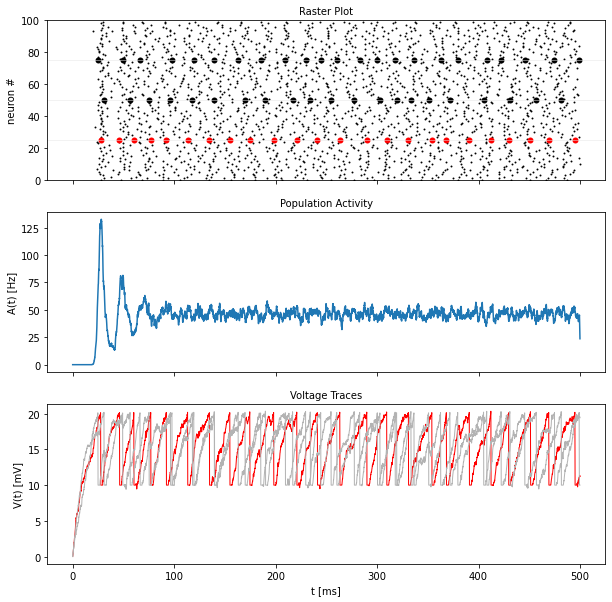

In [9]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=idx_monitored_neurons,\
                                 figure_size=(10, 10), t_min=0.*b2.ms)


Access the data in rate_monitor, spike_monitor, voltage_monitor

First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window. 

You can the time axis from rate_monitor.t

In [10]:
ts = rate_monitor.t / b2.ms
print(ts.shape)
t_min = 350; t_max = 500 

(5000,)


Now, vary the window width across which the rate is averaged and write down your observations (do plot!). 



INFO       width adjusted from 5. ms to 5.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


mean window 1: 46.25306666666667 Hz
mean window 2: 46.070013071895424 Hz


INFO       width adjusted from 20. ms to 20.1 ms [brian2.monitors.ratemonitor.adjusted_width]


mean window 3: 45.86954455445544 Hz
mean window 4: 45.4458839137645 Hz


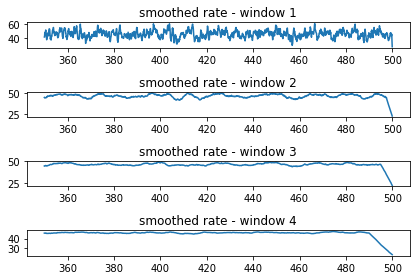

In [11]:
window_widths = [0.5,5,10,20]*b2.ms;

for i in range(0,4):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(4,1,i+1)
    plt.tight_layout()
    plt.plot(ts[-1500:],smoothed_rates[-1500:])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[-1500:])} Hz")

Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  

In [12]:
eventtrains = spike_monitor.event_trains(); # dict -> keys: 0 to 5000 (0.1 ms), values: events in that window of time

diff = np.zeros(5000)

for i in range(5000):
    diff[i] = np.mean(np.diff(eventtrains[0])) # take the mean of the ISIs in an interval of time of 0.1ms
    
mean_ISI = np.mean(diff) # the mean of all 500ms 

print(f"mean ISI: {mean_ISI} ms\nmean firing rate: {1 / mean_ISI} Hz") # mean firing rate is the reciprocal of the mean ISIs 

mean ISI: 0.020290909090909092 ms
mean firing rate: 49.283154121863795 Hz


<div class="alert alert-success">
<span style="color:black">

**A1.5 Answer** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

# 2. The pre-implemented Brunel network

Import the LIF_spiking_network function from neurodynex3.brunel_model and use this function to simulate a network consisting of 10000 excitatory neurons, 2500 inhibitory neurons and 1000 external neurons. 

Further, 
- w0 = 0.1 mV
- total simulated time of 500 ms
- the membrane time scale can be put to default (LIF_spiking_network.MEMBRANE_TIME_SCALE)
- the same goes for the firing threshold (LIF_spiking_network.FIRING_THRESHOLD)
- monitored_subset = 50
- synaptic delay is 1.5ms 

We will vary two parameters: g (an input parameter to simulate_brunel_network) and, second, the firing frequency of the external neurons $\nu_{extern}$. The latter should be expressed as a ratio multiplied with $\nu_{threshold}$. The frequency $\nu_{threshold}$ is the minimal poisson rate in the external neuronal population required to elicit firing in the network in the absence of any feedback. 

According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 

\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}

Does this expression make sense? 

For starters, you can use g=6 and $\nu_{extern} = 4\nu_{threshold}$

Calculate $\nu_{threshold}$ in function of the parameters mentioned above and the corresponding $\nu_{extern}$. And run the simulation. Make sure to output rate_monitor, spike_monitor, voltage_monitor and monitored_spike_idx.

Make sure to start each simulation with a "b2.start_scope()" statement. 

In [13]:
from neurodynex3.brunel_model import LIF_spiking_network
b2.start_scope()


In [14]:
theta = LIF_spiking_network.FIRING_THRESHOLD # firing_threshold
w0 = 0.1 * b2.mV
N_excit = 10000
N_inhib = 2500
N_ext = 1000
tau = 20 *b2.ms

v_threshold = theta / (N_ext * w0 * tau)
v_extern = 4 * v_threshold # v_extern = poisson_input_rate

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit=N_excit, N_Inhib=N_inhib, N_extern=N_ext, w0=w0, g=6, synaptic_delay=1.5*b2.ms, sim_time=500.*b2.ms, monitored_subset_size=50, poisson_input_rate=v_extern)

Plot the output using "plot_network_activity", make sure to add the "t_min" and "t_max" parameter and increase the figure size to figure_size=(10,10). 

INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 720x720 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24b7ec683c8>)

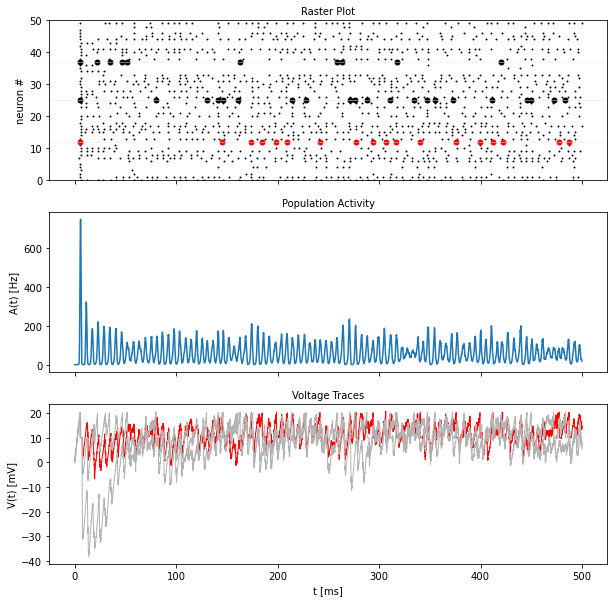

In [15]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min=0.*b2.ms,\
                                 figure_size=(10, 10))

The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 


INFO       width adjusted from 0.5 ms to 0.55 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 5. ms to 5.05 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 20. ms to 20.05 ms [brian2.monitors.ratemonitor.adjusted_width]


(10000,)
mean window 1: 59.716460606060615 Hz
mean window 2: 60.266006600660056 Hz
mean window 3: 60.416605153782214 Hz


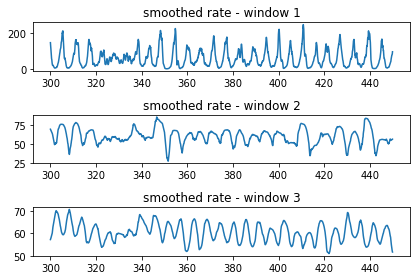

In [16]:
ts = rate_monitor.t / b2.ms
print(ts.shape)
t_min = 300; t_max = 450 

window_widths = [0.5, 5, 20]*b2.ms;

for i in range(0,3):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_widths[i])/b2.Hz
    
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    plt.plot(ts[6000:-1000],smoothed_rates[6000:-1000])
    plt.title(f"smoothed rate - window {i+1}")
    
    print(f"mean window {i+1}: {np.mean(smoothed_rates[6000:-1000])} Hz")

Next, we want to assess the global frequency content in rate_monitor. We know that if we have a time signal of 0.5 seconds, the maximal frequency resolution is 2 Hz. Be aware that Welch' method as implemented will chop the data in different pieces (to enable the averaging of the spectrum) yielding a smaller frequency resolution.  

Start by smoothing the rate with a window of 0.5 ms and calculate the spectrum using [signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). What is the sampling frequency fs? 

Plot the spectrum. What is the frequency resolution (look at np.diff(f)[0]). Can you explain how signal.welch arrives at this frequency resolution if you know that it - by default - includes 256 samples and if you check the integration time constant (typically 0.05 ms, but check b2.defaultclock.dt) that you used for the simulation? 

What happens if you impose nperseg = 256*8? 

What happens if you impose nfft = 10000 ? (Answer: you interpolate the spectrum). 

20000
freq_res: 2.0


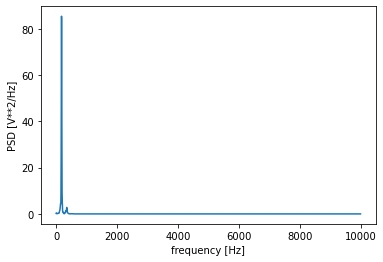

In [17]:
from scipy import signal

smoothed_rates = rate_monitor.smooth_rate(window='gaussian', width=0.5*b2.ms)

fs = 2 * len(ts) # nyquist criterium
print(fs)

f, Pxx_den = signal.welch(smoothed_rates, fs, nperseg=256*8, nfft=10000)

#print(max(Pxx_den)) # -> 81

print(f"freq_res: {np.diff(f)[0]}")

plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]') #power spectral density
plt.show()

We will now use the machinery provided by BRIAN to calculate and plot the power spectrum. BRIAN takes a slightly different approach. BRIAN starts from a desired frequency resolution, a desired number of windows over which the spectrum should be averaged and an initial time segment that should be ignored. Based on these desiredata, the minimal simulation length is calculated. 

Example: if we want a frequency resolution of 5 Hz, we need time windows of 200 ms. If we assume non-overlapping time windows and a number of averages the total simulated signal should be k*200ms. 

In this case, we have simulated 0.5 seconds of data. If we aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz, what is then the maximal number of windows we can include? 

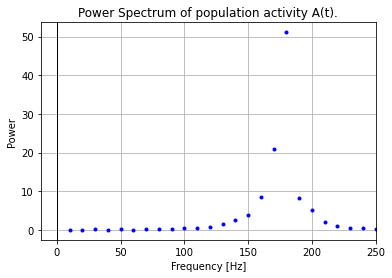

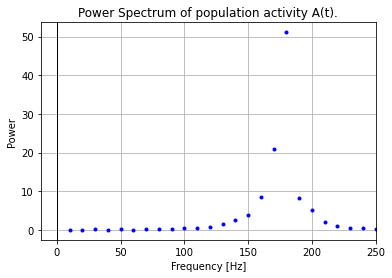

In [23]:
delta_f = 10*b2.Hz; 
k = 4 #trial and error 1,2,3,4
T_init = 99*b2.ms+b2.defaultclock.dt; 

pop_freqs, pop_ps, average_population_rate = \
    spike_tools.get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)

<div class="alert alert-success">
<span style="color:black">

**2 Answer** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here
    
\end{tcolorbox}
</span>

## 3 Explore the dynamics. 
Repeat the steps in ##2 for the following set of parameters: 

(A) g = 3, $\nu_{extern}/\nu_{threshold} = 2$ 

(B) g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

(C) g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Describe what you observe.

## A : g = 3, $\nu_{extern}/\nu_{threshold} = 2$

<div class="alert alert-success">
<span style="color:black">

**3A Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here
    
\end{tcolorbox}

</span>

## B : g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

<div class="alert alert-success">
<span style="color:black">

**3B Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here
    
\end{tcolorbox}

</span>

## C : g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

<div class="alert alert-success">
<span style="color:black">

**3C Answer** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here
    
\end{tcolorbox}
</span>